In [11]:
from lime import lime_image
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

In [12]:
model = tf.keras.models.load_model('../saved_model.h5')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-29 12:23:51.703996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-29 12:23:51.704133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
target = [
    'beagle', 'cocker_spaniel', 'golden_retriever',
    'maltese', 'pekinese', 'pomeranian', 'poodle',
    'samoyed', 'shih_tzu', 'white_terrier']


In [14]:
def img_preprocess(img_path):
    img = Image.open(img_path)
    img = img.resize((128, 128))
    img = img.convert('RGB')
    img = np.array(img)
    img = img / 255
    return img

In [99]:
def explain_image(img_path):
    img = img_preprocess(img_path)
    explainer = lime_image.LimeImageExplainer()

    # 이미지를 슈퍼픽셀로 분할하는 알고리즘 설정
    # quickshift, slic, felzenswalb 등이 존재
    segmenter = SegmentationAlgorithm('slic',
                                    n_segments=100,  # 이미지 분할 조각 개수
                                    compactnes=1,  # 유사한 파트를 합치는 함수
                                    sigma=1)  # 스무딩 역할: 0과 1사이의 float

    explanation = explainer.explain_instance(img,
                                            classifier_fn=model.predict,  # 10개 class 확률 반환
                                            top_labels=4,  # 확률 기준 1~5위
                                            num_samples=1000,  # sample space
                                            segmentation_fn=segmenter)  # 분할 알고리즘                                            
    
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
    
    plt.subplot(2, 2, 1)
    plt.title(f'Significant heatmap')
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.imshow(img, alpha=0.5)


    np_img = np.array([img])
    pred = model.predict(np_img)
    for i in range(len(target)):
        print(f'{target[i]} : {pred[0][i] * 100 : .2f}%')
    pred_idx = np.argmax(pred)
    print(f'This image is {pred[0][pred_idx] * 100 :.2f}% {target[pred_idx]}')

    ind = explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    
    plt.title("Weight of each segment")
    plt.subplot(2, 2, 2)
    plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
    plt.colorbar()


100%|██████████| 1000/1000 [00:08<00:00, 116.28it/s]


beagle :  0.00%
cocker_spaniel :  0.00%
golden_retriever :  0.00%
maltese :  0.00%
pekinese :  0.00%
pomeranian :  0.00%
poodle :  0.00%
samoyed :  0.00%
shih_tzu :  100.00%
white_terrier :  0.00%
This image is 100.00% shih_tzu


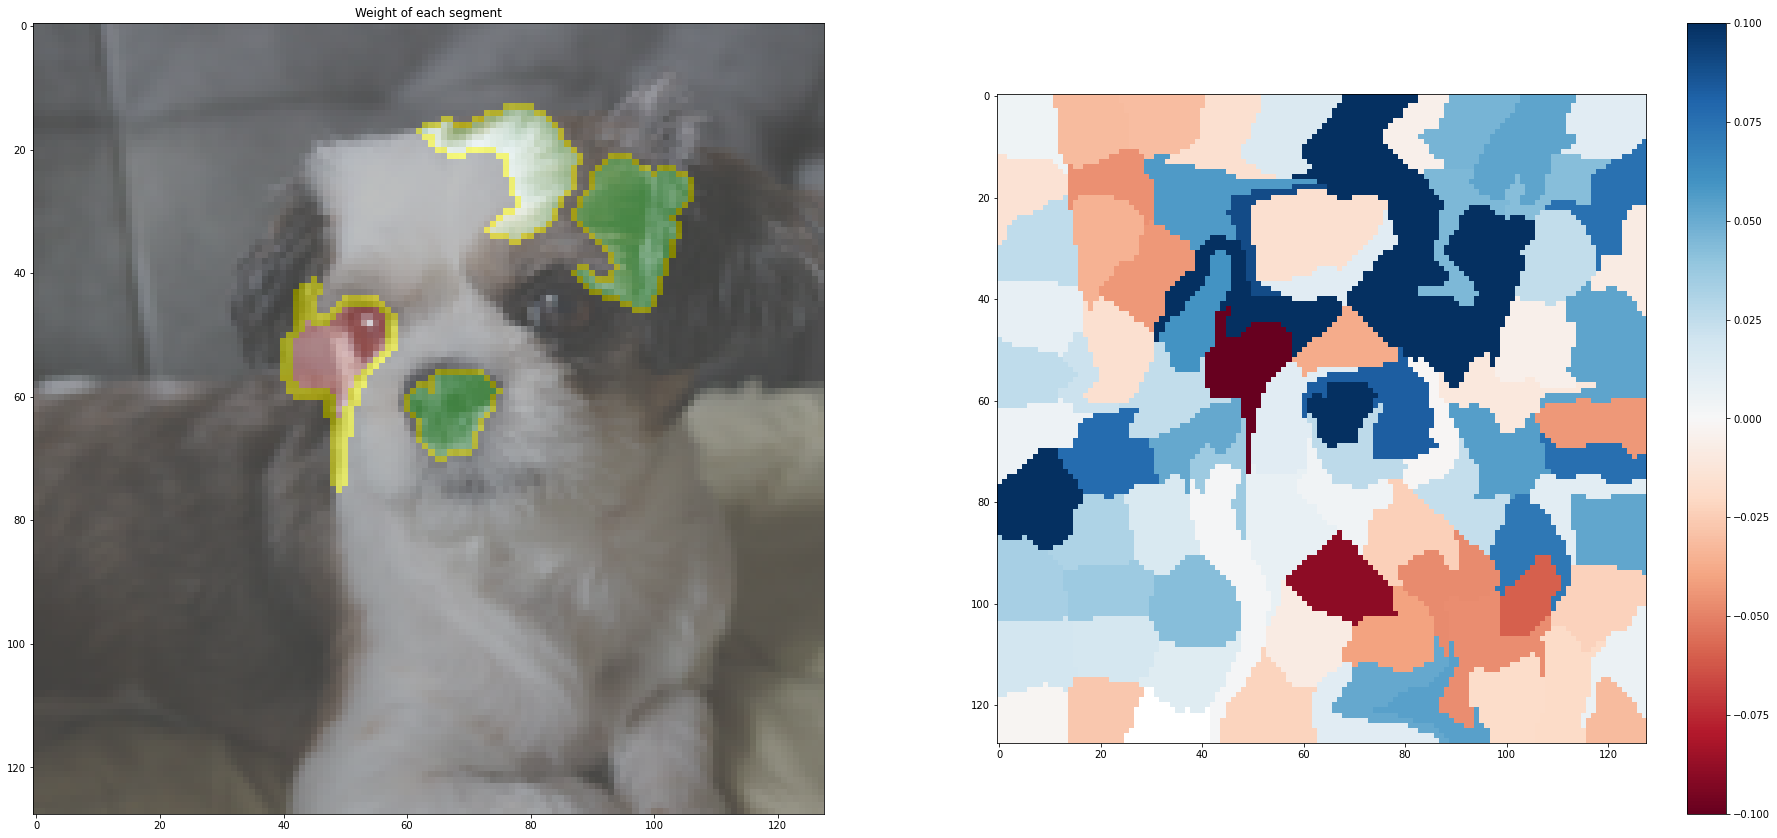

In [100]:
img_path = '../jjang.jpeg'
explain_image(img_path)

100%|██████████| 1000/1000 [00:13<00:00, 72.66it/s]


beagle :  0.00%
cocker_spaniel :  0.00%
golden_retriever :  0.00%
maltese :  93.16%
pekinese :  0.00%
pomeranian :  0.00%
poodle :  6.82%
samoyed :  0.00%
shih_tzu :  0.00%
white_terrier :  0.01%
This image is 93.16% maltese


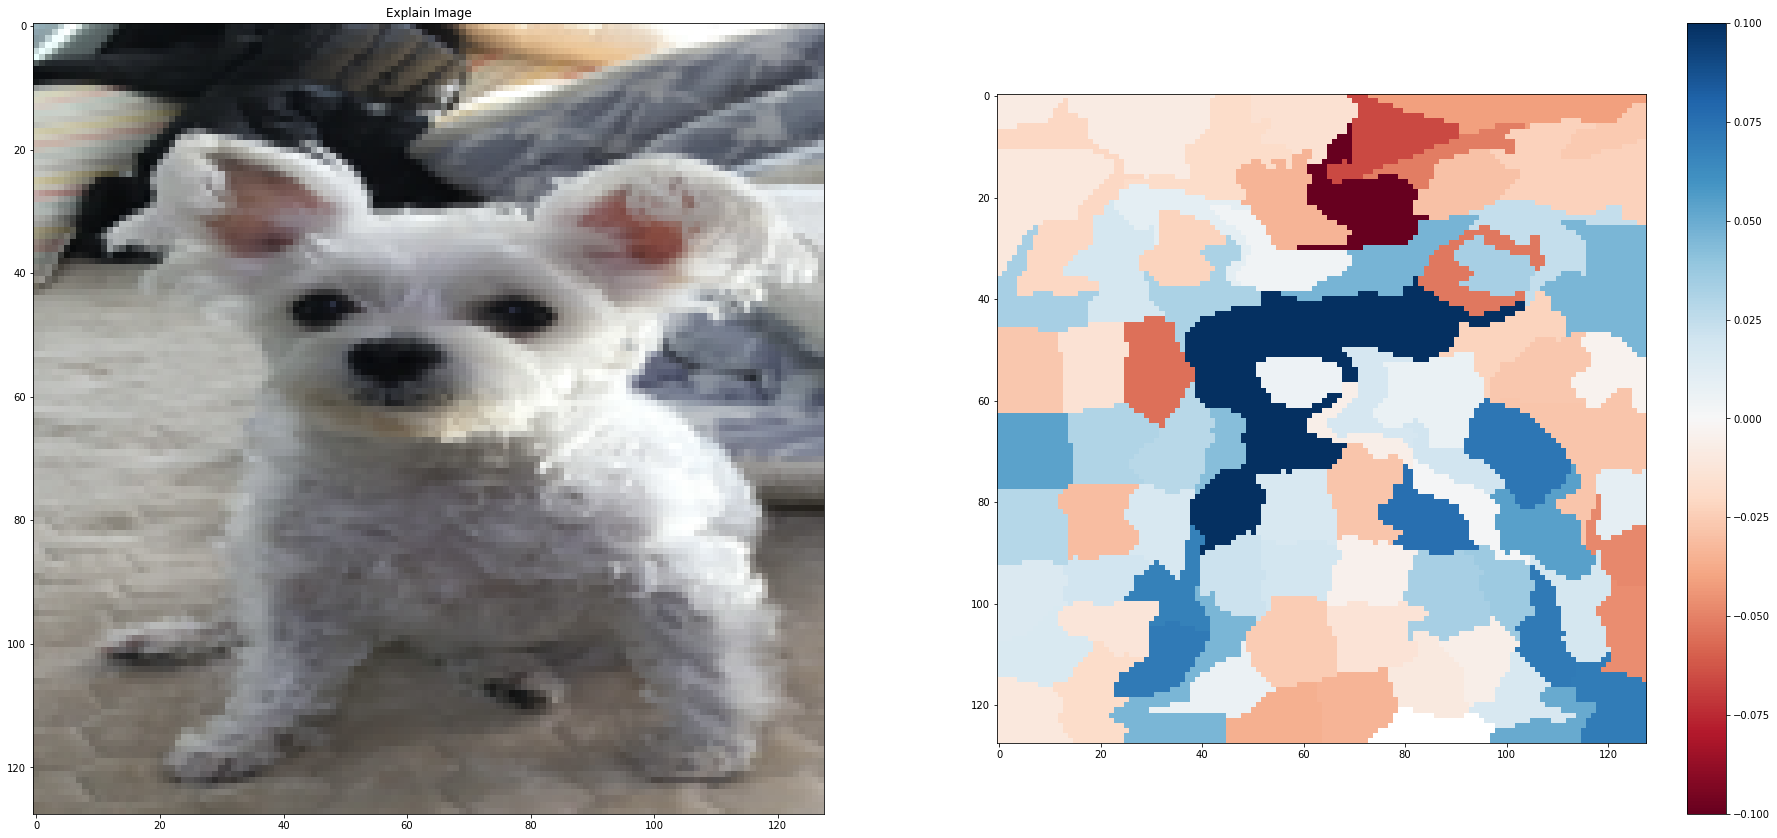

In [36]:
img_path = '../test_img/mint3.jpeg'
explain_image(img_path)


100%|██████████| 1000/1000 [00:15<00:00, 65.38it/s]


beagle :  0.00%
cocker_spaniel :  0.00%
golden_retriever :  0.00%
maltese :  0.00%
pekinese :  0.00%
pomeranian :  0.00%
poodle :  100.00%
samoyed :  0.00%
shih_tzu :  0.00%
white_terrier :  0.00%
This image is 100.00% poodle


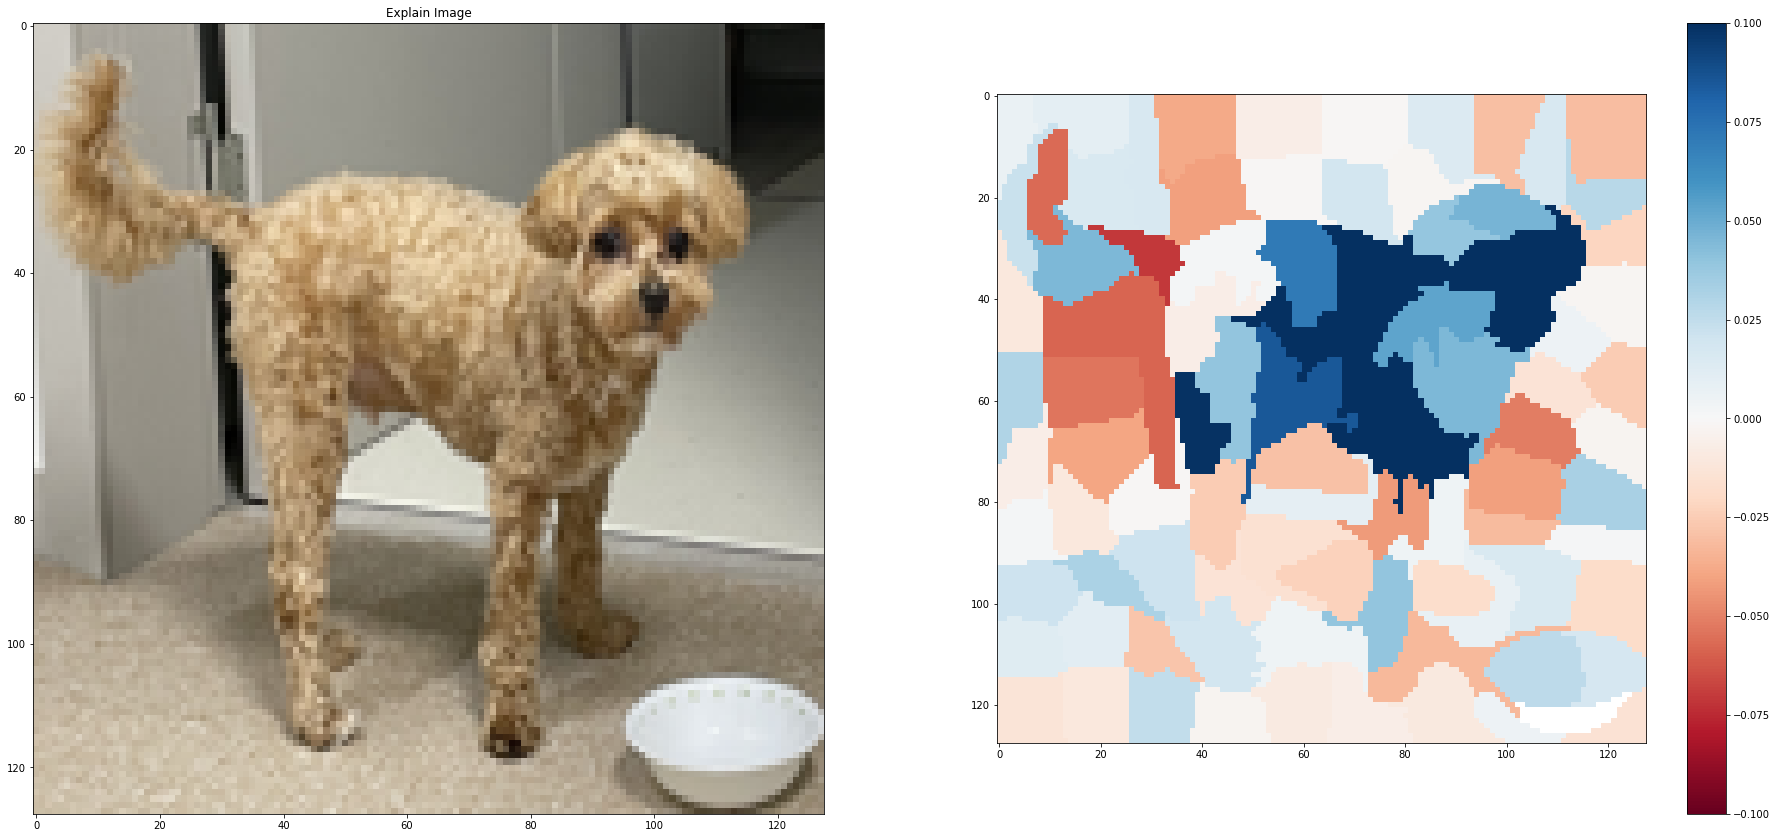

In [67]:
img_path = '../test_img/1.jpeg'
explain_image(img_path)


100%|██████████| 1000/1000 [00:15<00:00, 66.39it/s]


beagle :  0.00%
cocker_spaniel :  0.00%
golden_retriever :  0.00%
maltese :  0.00%
pekinese :  0.00%
pomeranian :  0.01%
poodle :  99.72%
samoyed :  0.00%
shih_tzu :  0.27%
white_terrier :  0.00%
This image is 99.72% poodle


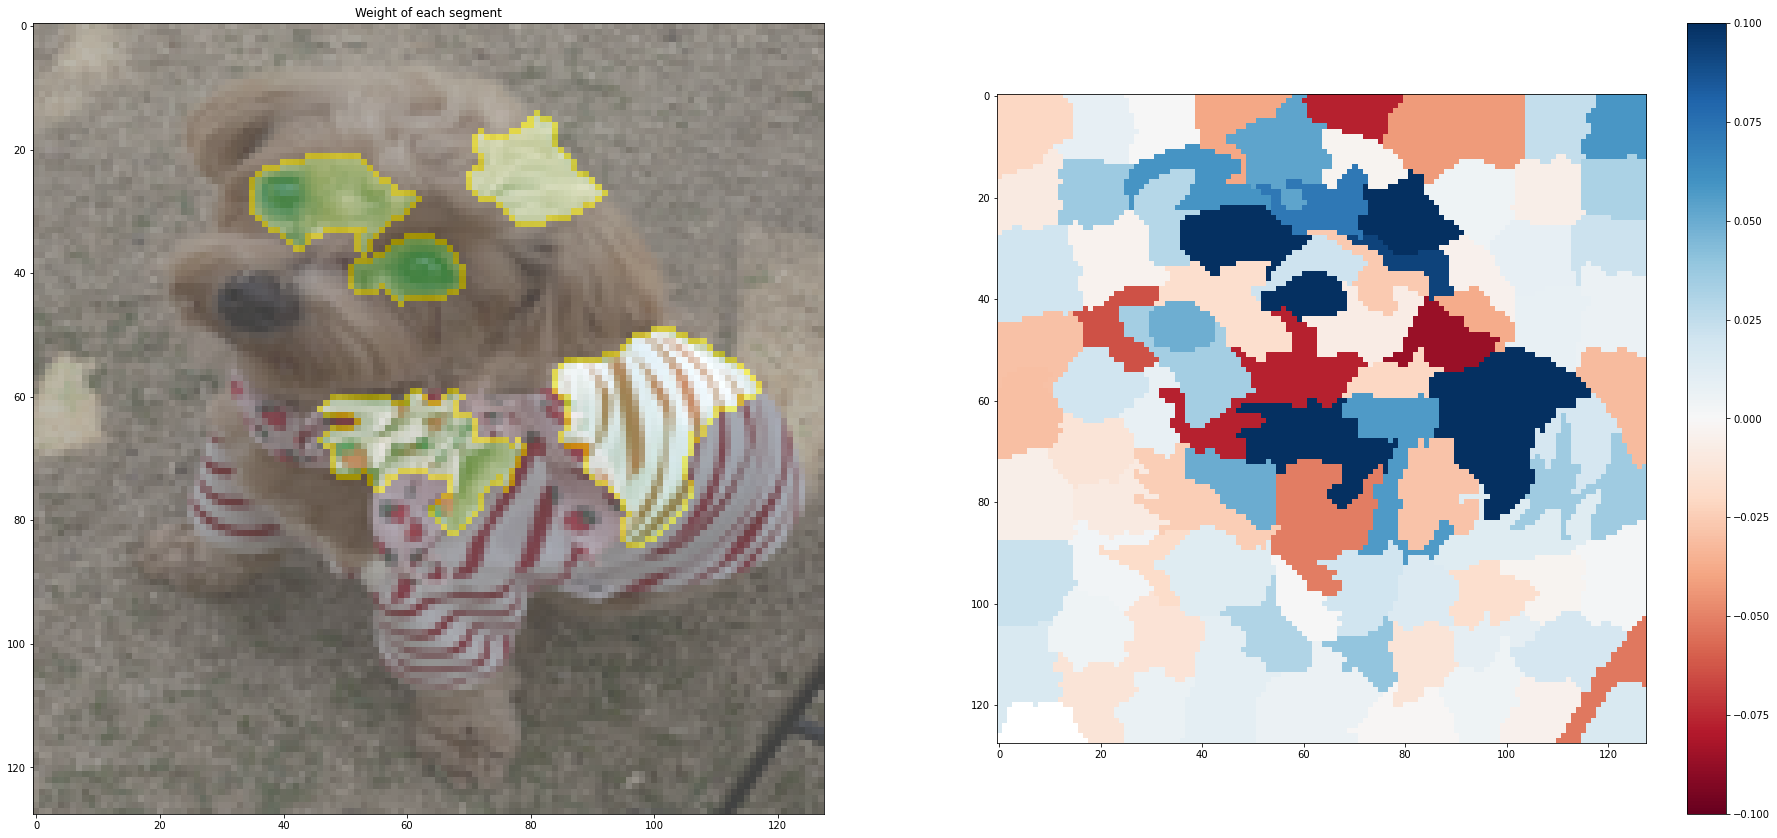

In [102]:
img_path = '../test_img/2.jpeg'
explain_image(img_path)


100%|██████████| 1000/1000 [00:13<00:00, 73.49it/s]


beagle :  0.00%
cocker_spaniel :  0.01%
golden_retriever :  0.00%
maltese :  0.07%
pekinese :  0.00%
pomeranian :  0.00%
poodle :  71.95%
samoyed :  0.00%
shih_tzu :  27.96%
white_terrier :  0.00%
This image is 71.95% poodle


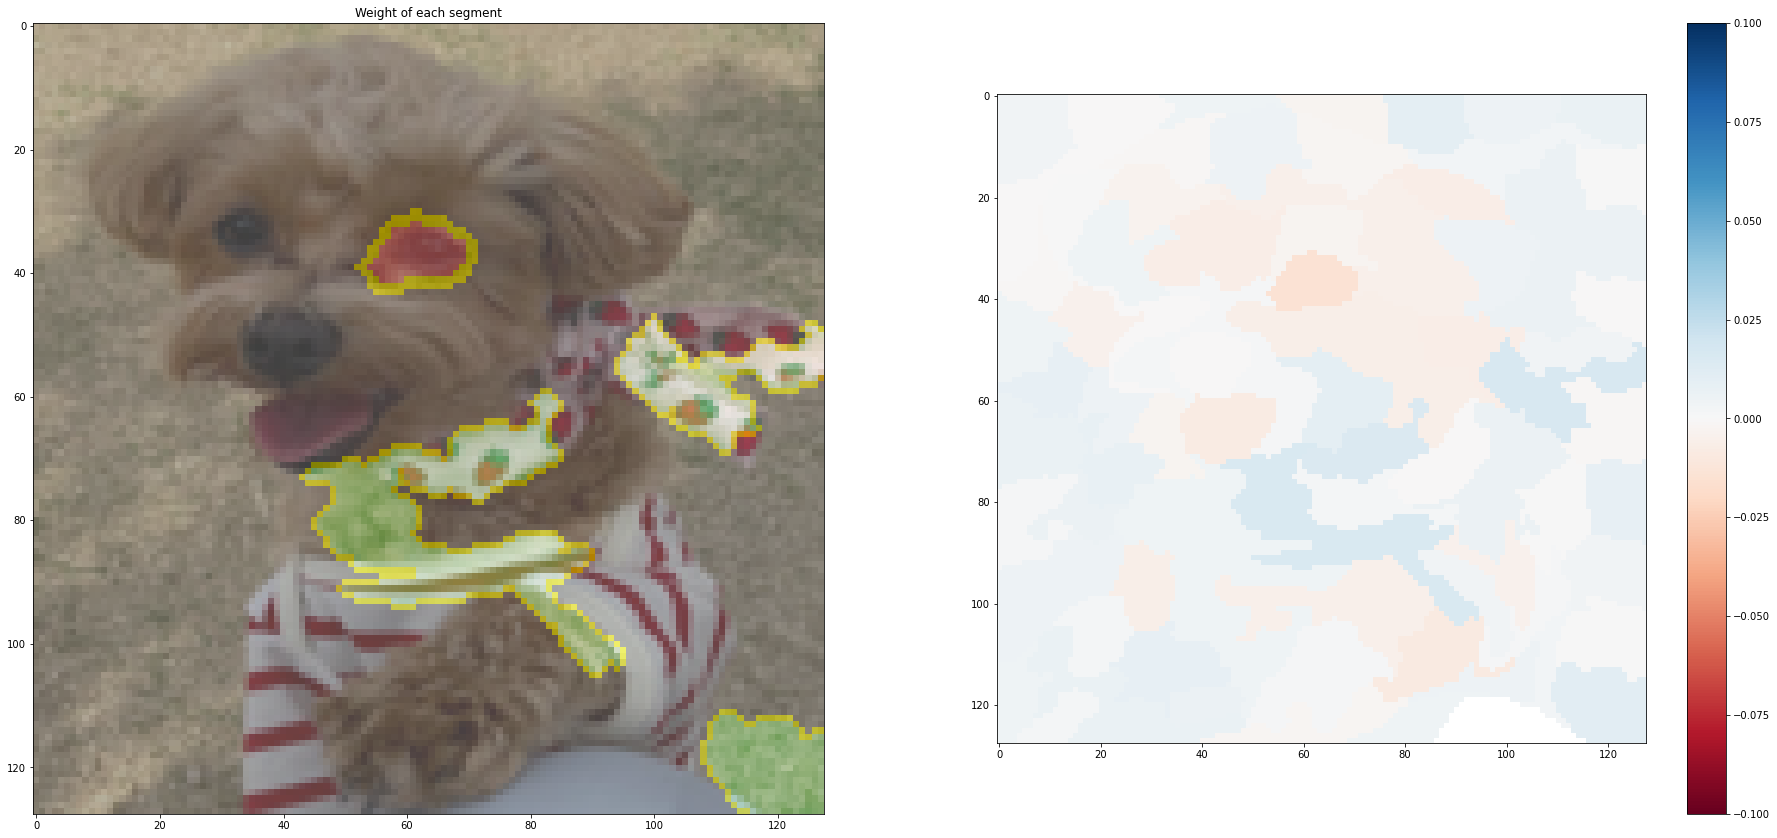

In [103]:
img_path = '../test_img/3.jpeg'
explain_image(img_path)


100%|██████████| 1000/1000 [00:13<00:00, 71.89it/s]


beagle :  0.00%
cocker_spaniel :  0.00%
golden_retriever :  0.00%
maltese :  100.00%
pekinese :  0.00%
pomeranian :  0.00%
poodle :  0.00%
samoyed :  0.00%
shih_tzu :  0.00%
white_terrier :  0.00%
This image is 100.00% maltese


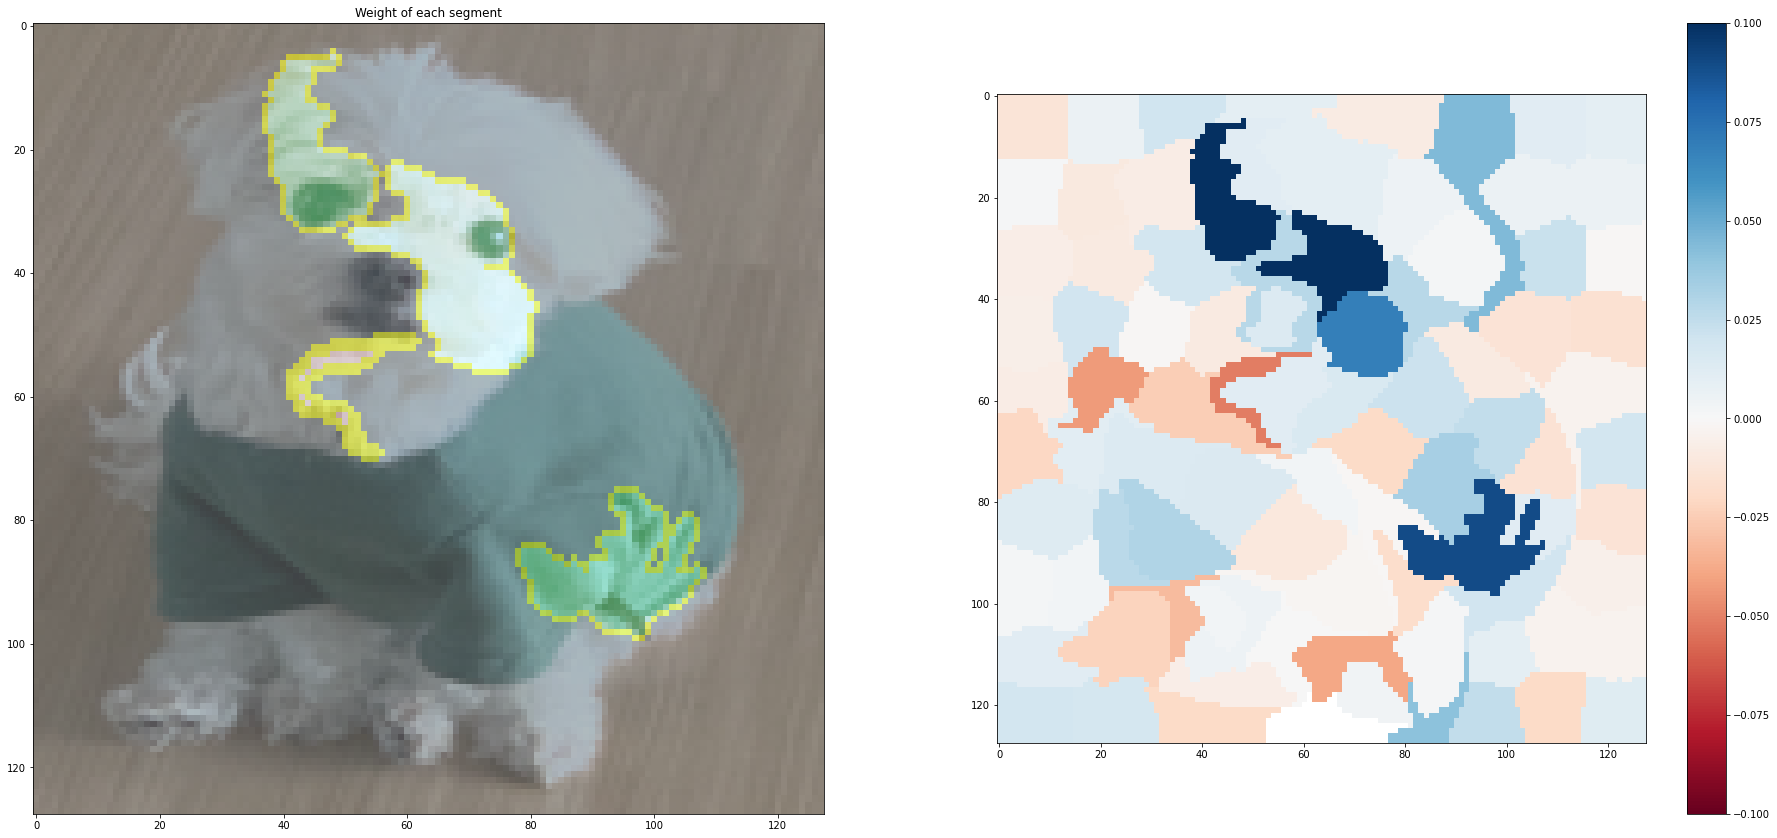

In [104]:
img_path = '../test_img/mal2.jpeg'
explain_image(img_path)
